<a href="https://colab.research.google.com/github/qwiksilva/cs224w-github-rec/blob/master/kubernetes_EARec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import pandas as pd
import numpy as np
import networkx as nx
from collections import Counter
from datetime import datetime
import time
from tqdm.auto import tqdm
from collections import defaultdict
from scipy import sparse
import time
import functools
import numpy as np
from scipy.optimize import fmin_bfgs, fmin_l_bfgs_b
import os
import array
from datetime import datetime as dt
from pprint import pprint
import pytz
import random
import joblib
import itertools
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

home = "/gdrive/My Drive/Colab Notebooks/cs224w-data/final-data-12062019"
os.listdir(home)

['final_comments_df_12062019.csv',
 'final_filepath_df_12062019.csv',
 'final_pr_list.npy',
 'pr_commenter_earec_12072019.csv',
 'pr_dist_index_map.joblib',
 'train_srw_output_v1.joblib',
 'train_node_mapping_v1.joblib',
 'test_srw_output_v1.joblib',
 'test_node_mapping_v1.joblib',
 'train_srw_output_v2.joblib',
 'train_node_mapping_v2.joblib',
 'test_srw_output_v2.joblib',
 'test_node_mapping_v2.joblib',
 'train_v2_comments_df.csv',
 'test_v2_comments_df.csv',
 'train_srw_output_v3.joblib',
 'train_node_mapping_v3.joblib',
 'test_srw_output_v3.joblib',
 'test_node_mapping_v3.joblib',
 'final-data-12062019',
 'expertise_result_12092019.joblib',
 'bad_train_pr_list_in_2018.joblib',
 'bad_test_pr_list_in_2018.joblib',
 'train_srw_output_v4_2018_only.joblib',
 'train_node_mapping_v4_2018_only.joblib',
 'test_comments_df_v4_2018_only.joblib',
 'test_srw_output_v4_2018_only.joblib',
 'test_node_mapping_v4_2018_only.joblib',
 'train_comments_df_v4_2018_only.joblib',
 'filepath_feat_df_v4_201

In [0]:
def load_data(suffix="v4_2018_only", path="/gdrive/My Drive/Colab Notebooks/cs224w-data/final-data-12062019"):
  "Load the required files"

  # train_srw_output = joblib.load(os.path.join(path, f"train_srw_output_{suffix}.joblib"))
  # train_node_mapping = joblib.load(os.path.join(path, f"train_node_mapping_{suffix}.joblib"))
  # test_srw_output= joblib.load(os.path.join(path, f"test_srw_output_{suffix}.joblib"))
  # test_node_mapping = joblib.load(os.path.join(path, f"test_node_mapping_{suffix}.joblib"))
  test_cosine_sim_matrix = joblib.load(os.path.join(path, f"test_cosine_sim_matrix_{suffix}.joblib"))
  test_pr_cosine_index_map = joblib.load(os.path.join(path, f"test_pr_cosine_index_map_{suffix}.joblib"))
  train_pr_cosine_index_map = joblib.load(os.path.join(path, f"train_pr_cosine_index_map_{suffix}.joblib"))

  dtypes = {
    'comment': str,
    'commenter_id': int,
    'commenter_login': str, 
    'pr_id': int,
    'user_id': int,
    'username':str,
    'title': str,
    'description': str,
    'pr_created_at': str,
    'comment_created_at': str,
  }

  train_comments = joblib.load(os.path.join(path, 'train_comments_df_v4_2018_only.joblib'))
  test_comments = joblib.load(os.path.join(path, 'train_comments_df_v4_2018_only.joblib'))

  comments = pd.concat([train_comments,test_comments])
  comments = comments.reset_index()

  data = {
      'test_cosine_sim_matrix':test_cosine_sim_matrix,
      'test_pr_cosine_index_map':test_pr_cosine_index_map,
      'train_pr_cosine_index_map':train_pr_cosine_index_map,
      'train_comments':train_comments,
      'comments':comments
  }
  return data


In [0]:
def convert_to_tic(s):
    #Jan, 1, 2014
    start_time = time.mktime(datetime(2018, 1, 1).timetuple())
    #Jan, 1, 2019
    end_time = time.mktime(datetime(2019, 1, 1).timetuple())
    time_delta = end_time-start_time
    return float(time.mktime(pd.to_datetime(s).timetuple()) - start_time) / time_delta

def path2List(fileString):
    return fileString.split("/")

def LCP(f1,f2):
    f1 = path2List(f1)
    f2 = path2List(f2)
    common_path = 0
    min_length = min(len(f1),len(f2))
    for i in range(min_length):
        if f1[i] == f2[i]:
            common_path += 1
        else:
            break
    common_path = common_path / max(len(f1), len(f2))
    return common_path

def get_pr_similarities(pr_obj1, pr_obj2, file_similarities):
    similarity = 0.0
    for filename1 in pr_obj1:
        for filename2 in pr_obj2: 
            if (filename1, filename2) in file_similarities:
                similarity += file_similarities[(filename1, filename2)]
            else:
                file_similarity = LCP(filename1, filename2)
                file_similarities[(filename1, filename2)] = file_similarity
                similarity += file_similarity

    similarity = similarity / (len(pr_obj1)*len(pr_obj2))
    return similarity

def create_user_to_user_graph(graph, data, pr_id='pr_id', commenter_id='commenter_id', owner_id='user_id'):
    print("converting times to tics")
    comment_times = data['comment_created_at'].map(convert_to_tic)
    data['weight'] = comment_times
    data = data.sort_values(by='weight')
    decay = 0.8

    print(f"finished times to tics, starting graph creation on {len(data)} rows")
    counts = Counter()
    for index, row in data.iterrows():
        if row[commenter_id] == row[owner_id]:
            continue
            
        row['weight'] *= decay**counts[(row[pr_id], row[commenter_id])]
        counts[(row[pr_id], row[commenter_id])] += 1

    print("finished counting, starting weight calculations")
    edge_weights = Counter()
    for index, row in data.iterrows():
        if row[commenter_id] == row[owner_id]:
              continue
              
        edge_weights[(row[commenter_id], row[owner_id])] += row['weight']

    print("finished weights, creating graph")
    for edge in edge_weights:
        graph.add_edge(edge[1], edge[0], weight=edge_weights[edge])

    return graph

def add_pr(graph, new_pr_id, pr_to_files, pr_to_users, comment_counts, file_similarities={}):
    if int(new_pr_id) in graph.nodes:
        print(f"Warning: found node already in graph with id {new_pr_id}")
        return graph
    
    edge_weights = Counter()
    new_pr_files = pr_to_files[new_pr_id]
    for pr_id in pr_to_users: 
        if pr_id == new_pr_id:
            continue
            
        pr_files = pr_to_files[pr_id]
        similarity = get_pr_similarities(new_pr_files, pr_files, file_similarities)
        for user_id in pr_to_users[pr_id]:
            edge_weights[user_id] += comment_counts[user_id][pr_id] * similarity
            
    for user_id in edge_weights:
        weight = edge_weights[user_id] / sum(comment_counts[user_id].values())
        graph.add_edge(new_pr_id, user_id, weight=weight)

    return graph

def add_pr_precomputed(graph, new_pr_id, new_pr_idx, pr_to_users, comment_counts, pr_similarities, train_pr_cosine_index_map):
    # graph.add_node(new_pr_id)
    
    edge_weights = Counter()
    for pr_id in pr_to_users:
            
        similarity = pr_similarities[new_pr_idx][train_pr_cosine_index_map[pr_id]]
        for user_id in pr_to_users[pr_id]:
            edge_weights[user_id] += comment_counts[user_id][pr_id] * similarity
            
    for user_id in edge_weights:
        weight = edge_weights[user_id] / sum(comment_counts[user_id].values())
        edge_weights[user_id] = weight

    # edges = sorted([edge for edge in graph.out_edges(new_pr_id, data='weight')], key=lambda x:x[2], reverse=True)
    # print("max edges", edges[:5])

    return edge_weights


In [0]:
def setup_add_pr(train_comments, file_paths, commenter_id='commenter_id'):
    t = time.time()
    grouped_comments = train_comments.groupby([commenter_id, 'pr_id']).size()
    grouped_files = file_paths.groupby(['pr_number'])

    comment_counts = {}
    for commenter_group in grouped_comments.index:
        if commenter_group[0] not in comment_counts:
            comment_counts[commenter_group[0]] = Counter()
        comment_counts[commenter_group[0]][commenter_group[1]] = grouped_comments[commenter_group]

    pr_to_users = {}
    grouped_prs = train_comments.groupby(['pr_id'])
    for pr_id, group in grouped_prs:
        pr_to_users[pr_id] = group[commenter_id].unique()

    pr_to_files = {}
    for name, group in grouped_files:
        pr_to_files[name] = group.filename.values

    elapsed = time.time() - t
    print(f"setup took {elapsed} sec")

    return comment_counts, pr_to_users, pr_to_files

def setup_add_pr_precomputed(train_comments, commenter_id='commenter_id'):
    t = time.time()
    grouped_comments = train_comments.groupby([commenter_id, 'pr_id']).size()
    # grouped_files = file_paths.groupby(['pr_number'])

    comment_counts = {}
    for commenter_group in grouped_comments.index:
        if commenter_group[0] not in comment_counts:
            comment_counts[commenter_group[0]] = Counter()
        comment_counts[commenter_group[0]][commenter_group[1]] = grouped_comments[commenter_group]

    pr_to_users = {}
    grouped_prs = train_comments.groupby(['pr_id'])
    for pr_id, group in grouped_prs:
        pr_to_users[pr_id] = group[commenter_id].unique()

    # pr_to_files = {}
    # for name, group in grouped_files:
    #     pr_to_files[name] = group.filename.values

    elapsed = time.time() - t
    print(f"setup took {elapsed} sec")

    return comment_counts, pr_to_users

In [0]:
data = load_data()
test_cosine_sim_matrix = data['test_cosine_sim_matrix']
test_pr_cosine_index_map = data['test_pr_cosine_index_map']
train_pr_cosine_index_map = data['train_pr_cosine_index_map']
train_comments = data['train_comments']

graph = nx.DiGraph()
graph = create_user_to_user_graph(graph, train_comments)


converting times to tics
finished times to tics, starting graph creation on 31064 rows
finished counting, starting weight calculations
finished weights, creating graph


In [0]:
commenters = set(train_comments['user_id'].unique())
authors = set(train_comments['commenter_id'].unique())
both = commenters.union(authors)
print(len(commenters - authors)/len(both))
print(len(authors - commenters)/len(both))

0.03225806451612903
0.27489481065918653


In [0]:
earec = graph
[len(c) for c in sorted(nx.weakly_connected_components(earec), key=len, reverse=True)]

[713]

In [0]:
print('Nodes', len(earec.nodes()))
print('Edges', len(earec.edges()))
print('average_shortest_path_length', nx.average_shortest_path_length(earec))
print('average_clustering', nx.algorithms.cluster.average_clustering(earec))

Nodes 713
Edges 3714
average_shortest_path_length 1.1069090092503584
average_clustering 0.19346080646025235


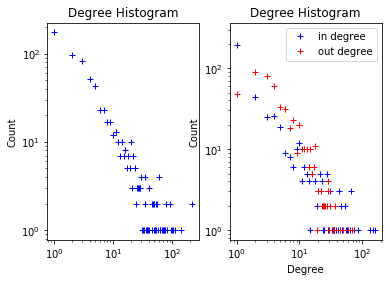

In [0]:


degree_sequence = sorted([d for n, d in earec.degree()], reverse=True)
degreeCount = Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(deg, cnt, '+', color='b')
ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.set_title("Degree Histogram")
ax1.set_ylabel("Count")
ax1.set_label("Degree")

degree_sequence = sorted([d for n, d in earec.in_degree()], reverse=True)
degreeCount = Counter(degree_sequence)
deg_in, cnt_in = zip(*degreeCount.items())

degree_sequence = sorted([d for n, d in earec.out_degree()], reverse=True)
degreeCount = Counter(degree_sequence)
deg_out, cnt_out = zip(*degreeCount.items())

ax2.plot(deg_in, cnt_in, '+', color='b', label='in degree')
ax2.plot(deg_out, cnt_out, '+', color='r', label='out degree')
ax2.set_yscale('log')
ax2.set_xscale('log')

ax2.set_title("Degree Histogram")
ax2.set_ylabel("Count")
ax2.set_xlabel("Degree")
ax2.legend()

fig.savefig("degree_hist.png", format="PNG")

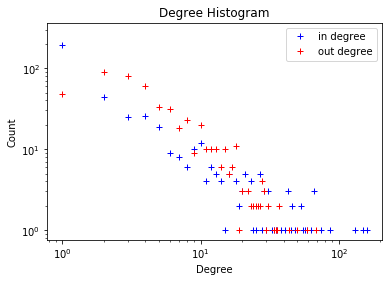

In [0]:
degree_sequence = sorted([d for n, d in earec.in_degree()], reverse=True)
degreeCount = Counter(degree_sequence)
deg_in, cnt_in = zip(*degreeCount.items())

degree_sequence = sorted([d for n, d in earec.out_degree()], reverse=True)
degreeCount = Counter(degree_sequence)
deg_out, cnt_out = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.plot(deg_in, cnt_in, '+', color='b', label='in degree')
plt.plot(deg_out, cnt_out, '+', color='r', label='out degree')
ax.set_yscale('log')
ax.set_xscale('log')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.legend()
plt.savefig("dir_degree_hist.png", format="PNG")

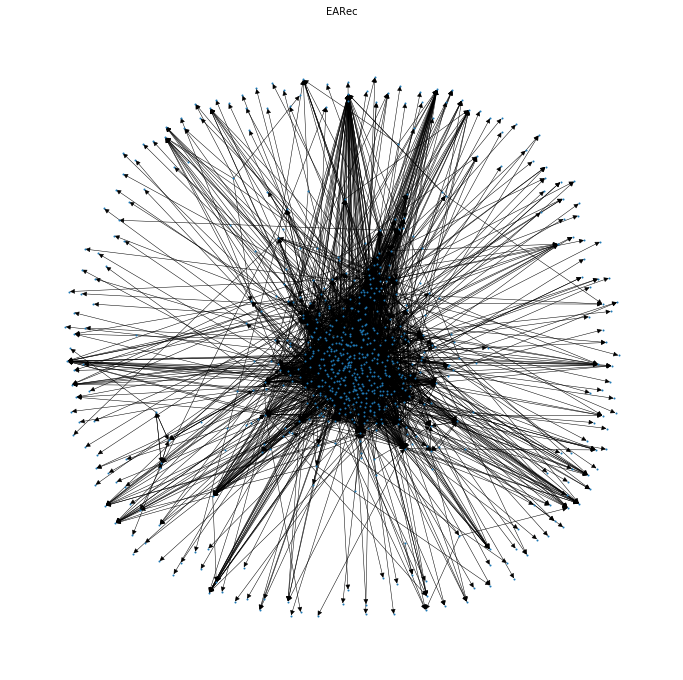

In [0]:
fig = plt.figure(figsize=(12,12))
ax = plt.subplot(111)
ax.set_title('EARec', fontsize=10)
pos = nx.spring_layout(earec)
nx.draw(earec, pos, node_size=1, width=0.5)
plt.savefig("earec_vis.png", format="PNG")

In [0]:
comment_counts, pr_to_users = setup_add_pr_precomputed(train_comments)
weights = {}
for new_pr_id in tqdm(test_pr_cosine_index_map):
  weights[new_pr_id] = add_pr_precomputed(graph, new_pr_id, test_pr_cosine_index_map[new_pr_id], pr_to_users, comment_counts, test_cosine_sim_matrix, train_pr_cosine_index_map)


setup took 2.2630884647369385 sec


In [0]:
test_prs = test_pr_cosine_index_map
pageranks = {}
pr_scores = {}
sim_scores = {}
alpha = 0.05

i = 0
for new_pr_id in tqdm(test_pr_cosine_index_map):
    new_pr_node = "p"+str(new_pr_id)
    pagerank_dict = nx.pagerank(graph, personalization=weights[new_pr_id], alpha=alpha, weight='weight')
    scores = sorted([(k, v) for k, v in pagerank_dict.items()], key= lambda x: x[1], reverse=True)
    pageranks[new_pr_id] = scores



In [0]:
_ = generate_results(pageranks, test_dict, top_k=10, verbose=True)

In [0]:
joblib.dump(pageranks, os.path.join(home, 'EARec_best_result_12102019.joblib'))

['/gdrive/My Drive/Colab Notebooks/cs224w-data/final-data-12062019/EARec_best_result_12102019.joblib']

In [0]:
sim_scores = {}
for k, v in weights.items():
  sim_scores[k] = sorted([(k_, v_) for k_, v_ in v.items()], key= lambda x: x[1], reverse=True)
# sim_scores = sorted([(k, v) for k, v in weights.items()], key= lambda x: x[1], reverse=True)
_ = generate_results(sim_scores, test_dict, top_k=10, verbose=True)

Top-10-Average-Precision = 0.003
Top-10-Average-Recall = 0.010
Top-10-Average-F1 = 0.004
Average-MRR = 0.011


In [0]:
alphas = [0, .025, .05, .1, .25, .5, .75, .9, 1.0]
aps = [0.003, 0.056, 0.062, 0.060, 0.060, 0.056, 0.056, .056, 0.055]
ars = [0.010, 0.224, 0.249, 0.239, 0.238, 0.219, 0.216, .221, 0.214]
f1s = [0.004, 0.086, 0.094, 0.091, 0.091, 0.085, 0.084, 0.085, 0.083]
mrrs = [0.011, 0.119, 0.127, 0.126, 0.124, 0.124, 0.122, 0.119, 0.122]

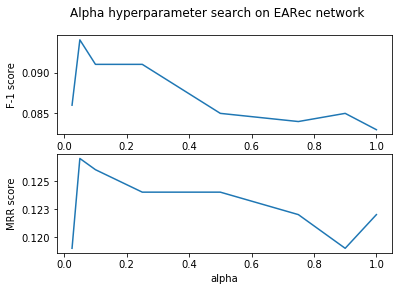

In [0]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Alpha hyperparameter search on EARec network ')
ax1.plot(alphas[1:], f1s[1:])
ax1.set(ylabel='F-1 score')
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

ax2.plot(alphas[1:], mrrs[1:])
ax2.set(xlabel='alpha', ylabel='MRR score')
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

fig.savefig('EARec_param_graph.PNG')

In [0]:
pagerank_dict = nx.pagerank(graph, alpha=.75, weight='weight')
pagerank_items = sorted(pagerank_dict.items(), key=lambda x:x[1], reverse=True)
baseline = {pr_id:pagerank_items for pr_id in test_pr_cosine_index_map}

_ = generate_results(baseline, test_dict, top_k=10, verbose=True)

Top-10-Average-Precision = 0.055
Top-10-Average-Recall = 0.214
Top-10-Average-F1 = 0.083
Average-MRR = 0.122


In [0]:
train_comments_df = joblib.load(os.path.join(home, 'train_comments_df_v4_2018_only.joblib'))
test_comments_df = joblib.load(os.path.join(home, 'test_comments_df_v4_2018_only.joblib'))
filepath_summary_df = joblib.load(os.path.join(home, 'filepath_feat_df_v4_2018_only.joblib'))
train_dict = joblib.load(os.path.join(home, 'train_dict_v4_2018_only.joblib'))
test_dict = joblib.load(os.path.join(home, 'test_dict_v4_2018_only.joblib'))

def generate_results(pred_dict, test_dict, top_k=10, verbose=False):
    ap = 0.0
    ar = 0.0
    amrr = 0.0
    af1 = 0.0
    for test_pr_id, gt_test_reviewers in test_dict.items():
        # if test_pr_id not in pred_dict:
        #   continue
          
        pred = pred_dict[test_pr_id]
        ranked_candidates = np.array([cand for cand, score in sorted(pred, key=lambda x: x[1], reverse=True)])
        pred_set = set(ranked_candidates[:top_k])
        actual_set = set(gt_test_reviewers)
        print(pred_set, actual_set)
        precision = len(pred_set & actual_set) / len(pred_set)
        recall = len(pred_set & actual_set) / len(actual_set)
        f1 = (2 * precision * recall) / (precision + recall + 10**(-10))
        gt_rank = []
        mrr = 0.0
        for gt_reviewer in gt_test_reviewers:
            lookup = np.argwhere(ranked_candidates == gt_reviewer).tolist()
            if len(lookup) == 0:
                rank = 0
            else:
                rank = lookup[0][0] + 1
                mrr += 1/rank
            gt_rank.append(rank)
        amrr += mrr/len(gt_rank)
        ap += precision
        ar += recall
        af1 += f1
    if verbose:
        print("Top-%d-Average-Precision = %0.3f\nTop-%d-Average-Recall = %0.3f\nTop-%d-Average-F1 = %0.3f\nAverage-MRR = %0.3f" 
            %(top_k, ap/len(test_dict), top_k, ar/len(test_dict), top_k, af1/len(test_dict), amrr/len(test_dict)))
    return ap/len(test_dict), ar/len(test_dict), af1/len(test_dict), amrr/len(test_dict)